<a href="https://colab.research.google.com/github/andalmod/Test/blob/main/Bayes_update_normal_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !pip install pymc3>=3.8

  Created wheel for empiricaldist: filename=empiricaldist-0.6.0-cp36-none-any.whl size=10357 sha256=1df946424014512db431d1e343c6bbbb340d6221500e8fa0cfca95d60dff31ad
  Stored in directory: /root/.cache/pip/wheels/a7/18/38/f4791357371b1d677a885149b397cb1437c0ea88939ab642e7
Successfully built empiricaldist


Thanks to Allen Downey.

https://youtu.be/EYS3oDhLsP0


In [2]:
from empiricaldist import Cdf

def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    Cdf.from_seq(sample).plot(**options)
def set_colors():
    """Set the color cycle for goals"""
    plt.gca().set_prop_cycle(color=['#2ca02c', '#9467bd',])

In [3]:
def quantiles(array):
  lb=np.quantile(array,0.025)
  ub=np.quantile(array,0.975)
  return lb,ub

In [4]:
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import halfnorm
import pandas as pd

Suppose the cost of something follows a Normal distribution (80,10)

In [5]:
cost_r=norm(80,10)

In [13]:
# Suppose we have some samples from the real distribution
size=10
samples=cost_r.rvs(size)

In [14]:
#We have some prior assumptions about the parameters of the distribution
#Let's sample from that prior

model=pm.Model()

with model:
    # define priors
    mu = pm.Normal('mu', 100, 20)
    sigma = pm.HalfNormal('sigma', 25)
    prior=pm.Normal('prior',mu,sigma)

    trace_p = pm.sample_prior_predictive(1000)

In [15]:
# Now we use the data to update our distribution.
# Let's sample now from the posterior

model1=pm.Model()

with model1:

  mu = pm.Normal('mu', 100, 20)
  sigma = pm.HalfNormal('sigma', 25)

  obs=pm.Normal('observation', mu,sigma, observed=samples)

  trace = pm.sample(1000)
  post_pred = pm.sample_posterior_predictive(trace, samples=1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 1000/1000 [00:00<00:00, 1092.02it/s]


In [16]:
#Now we take samples from prior, posterior and real and store them in numpy arrays.


pp=post_pred['observation'].flatten()
size=1000
samples_r=cost_r.rvs(size)

# These are the final numpy arrays containing the information we want

pr=trace_p['prior']
post=pp
real=samples_r




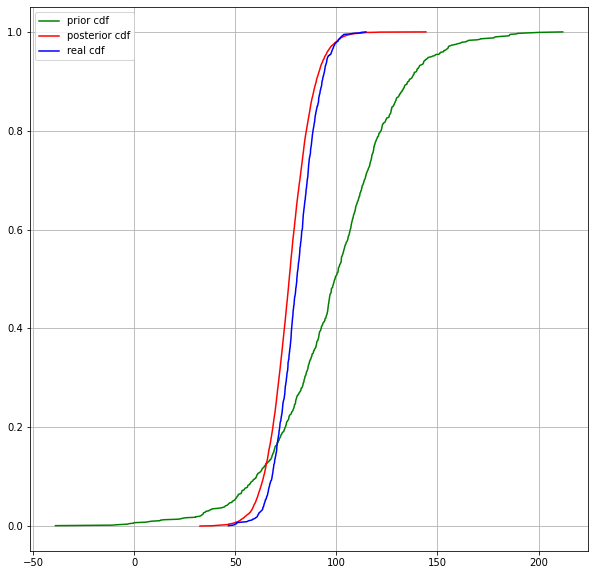

In [17]:
#Now let's plot the results.
#It's interesting to play with the size of the sample from the real distribution 
#in order to see how little data is needed to approach the real distribution very well.
#A frequentist could never have reached these useful results.

set_colors()
plot_cdf(pr, color='green', label='prior cdf',figsize=(10,10))
plot_cdf(post, color='red', label='posterior cdf')
plot_cdf(real, color='blue', label='real cdf')
plt.legend()
plt.grid();

In [19]:
# Let's get the quantiles for 95% confidence interval and show them

lb_prior,ub_prior=quantiles(pr)
lb_post,ub_post=quantiles(post)
lb_r,ub_r=quantiles(real)

index=['priori','posteriori','real']
columns=['distirb.','quant 2.5','quant 97.5']
q2_5=[lb_prior,lb_post,lb_r]
q97_5=[ub_prior,ub_post,ub_r]

df=pd.DataFrame(index=index)

df['quant 2.5']=q2_5
df['quant 97.5']=q97_5

df


,quant 2.5,quant 97.5
priori,34.138312,159.221342
posteriori,56.623042,98.456096
real,61.583736,99.187652
